<a href="https://colab.research.google.com/github/skylerchiu/SYDE535HW1/blob/main/SYDE535_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='orange'> SYDE 535 - Computational Simulations for Societal and Environmental Systems </font>

<font color='orange'> HW1 Learning goals: </font>

*   Confidently build a simulation for a well-established problem
*   Collect empirical data and use it to justify modelling decisions/assumptions





---



# Imports

Install the packages that are necessary for this example. As you get more familiar with coding in Python you will add/remove some of these packages and install your preferred ones. For now, you can simple execute this cell to install what is needed.

In [5]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

! pip install geopandas
! pip install geopy
! pip install -U plotly

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import csv
import math
import numpy as np
import scipy
from scipy import stats as sts
import plotly.express as px
from numpy.random import default_rng
from plotnine import *
import time
import matplotlib.pyplot as plt

rng = default_rng(13)

Mounted at /content/drive/


# <font color='orange'> Question 1 [50 points] </font>

## <font color='orange'> Data </font>

This example will use some data. You must tell the notebook where to look for these data. Here, I am telling that the data is in my google drive (/content/drive/MyDrive/) in a folder called 'Courses' in a subfolder called 'SYDE_599'. You can download the data for this example from LEARN and save at your preferred location in your computer, you just need to point the notebook to where the data are.

In [6]:
# Modify this according to the path in your computer
main_dir = '/content/drive/MyDrive/SYDE 535/'

Read the data for this example and plot the first 3 rows.

In [7]:
# pd.read_csv(path to file) reads the file in the provided path
df_Alameda = pd.read_csv(main_dir + 'Alameda.csv')

# Print the first (n) terms of the dataframe
df_Alameda.head(3)

Latitude   Longitude             UseCategory  Buildings  Units  Stories  \
0  37.756951 -122.237670  Single-family Detached          1      1        1   
1  37.734668 -122.239088  Single-family Detached          1      1        1   
2  37.734820 -122.233459  Single-family Detached          1      1        1   

   Rooms  Beds  YearBuilt  Baths  Area  LandValue  ImprovementValue  \
0      6     3       1900    1.0  1134      54029             12106   
1      6     4       1957    2.0  1196      34300             40577   
2      4     2       1952    1.0  1223      40353             40802   

   HomeValue  LatestDocument  
0      66135            1969  
1      74877            1969  
2      81155            1969

In [8]:
# And plot a map with the data underneath
df_Alameda['YearBuilt'] = df_Alameda['YearBuilt'].apply(lambda x: 1900 if x < 1900 else x)
df_plt = df_Alameda.copy()
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'YearBuilt',
                        color_continuous_scale='Viridis',
                        zoom=12.2,
                        height=700,
                        width=800
                      )
fig.show()

## <font color='orange'> Disclaimer </font>

This example will apply some concepts of Probabilistic Seismic Hazard Analysis and Regional Risk Assessment. You are *NOT* required to learn these concepts. In fact, this HWA is meant to teach you can use concepts discussed in class to explain problems you are not familiar with.

The goal of this HWA is to teach about modeling & simulations. In the following, I provide some context of what is being done and why. It should be sufficient for you to be able to complete this HWA.

The concepts presented in the following are very close to what is employed in practice. However, I simplified some steps to allow you to focus on the goals of the HWA.

## <font color='orange'> Hazard (a.k.a., the earthquake) </font>

In this HWA you are given a *simplified* worflow to simulate the impacts of earthquakes to a community. Earthquakes often occur across fault lines, which are (put simply) cracks on Earth's crust. One of the most dangerous California fault lines is the Hayward Fault in the San Francisco Bay Area (shown below as the black strip going from SE to NW). The Hayward Fault crosses multiple populated areas and if an earthquake occurs in this fault it can cause severe losses (monetary and societal).

Earthquakes are characterized by an *Epicentre* and a *Magnitude*. For this example, assume that the epicentre is the location where the earthquake occurs along the fault line (see here for more details [link text](https://www.usgs.gov/programs/earthquake-hazards/science-earthquakes#:~:text=The%20location%20below%20the%20earth's,the%20larger%20earthquake%20that%20follows.)).

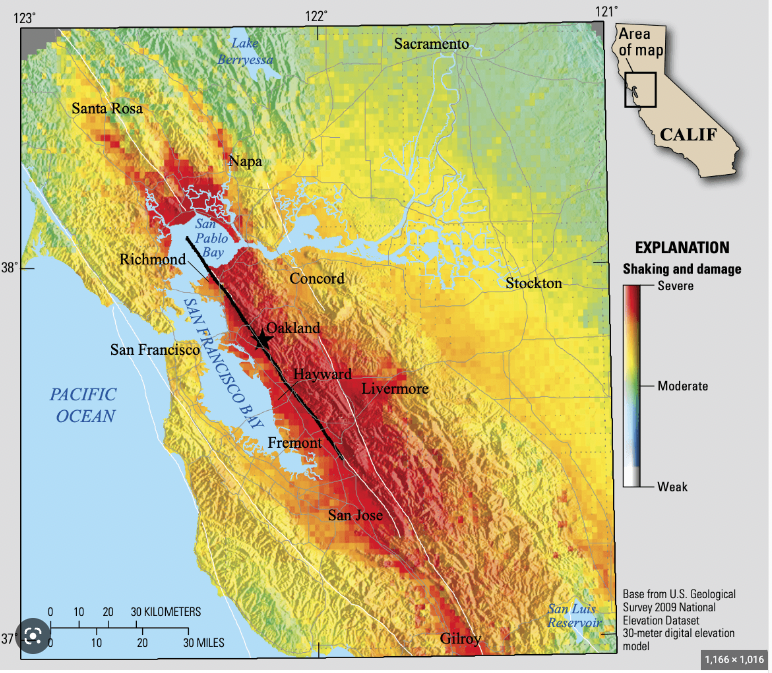

In [9]:
# Here, we will simulate the epicentre of the earthquake as a random variable
# uniformly distributed across the fault line. Say the fault line is
# sufficiently-well approximated by a line (this is an approximation since
# the earth is not flat :) ), hence it can be described by two points.
theNWPoint = (37.987, -122.390) # Northwest end of the Hayward fault (approximated)
theSWPoint = (37.603, -122.054) # Southeast end of the Hayward fault (approximated)

# Difference in latitudes
theDeltaLatitude = theNWPoint[0] - theSWPoint[0]

# Difference in longitudes
theDeltaLongitude = theNWPoint[1] - theSWPoint[1]

# Difference in degrees between the two points, i.e., length of the fault line
theTotalDelta = np.sqrt(theDeltaLatitude**2 + theDeltaLongitude**2) #sqrt = squared root

# Angle that the fault makes with the Equator (or any other parallel)
theAngleOfFault = np.arcsin(theDeltaLatitude / theTotalDelta)


# We want to simulate the occurrence of earthquake along the Hayward Fault.
# Let's assume that the epicentre location is equally likely to be anywhere along the fault line.
def simulateEpicentreLocation():
    # The distance between the fault end points is theTotalDelta
    #           0 ----------------- 1

    # First, simulate an epicentre location along this fault line
    theDistanceAlongTheFaultLine = rng.random() * theTotalDelta

    # Say theDistanceAlongTheFaultLine = 0.2 of theTotalDelta, we are saying that the epicentre location is around this region
    #           0 ---E------------ 1

    # However, the fault line is 'inclined'. We need to calculate the projection of the point E on the parallels and meridians.
    # This is just trigonometry
    # Note: these calculations are more complicated in non-Euclidian spaces hence we simplify them
    theEpicentreLatitude = theSWPoint[0] + theDistanceAlongTheFaultLine * np.sin(theAngleOfFault)
    theEpicentreLongitude = theSWPoint[1] - theDistanceAlongTheFaultLine * np.cos(theAngleOfFault)


    # Return the latitude and longitude
    return theEpicentreLatitude,theEpicentreLongitude

# Everything inside the 'def' block above is a function
# You can call (i.e., use) a function as
simulateEpicentreLocation() # which will give one potential epicentre location

(37.93508227341437, -122.34457198923758)

In [10]:
# Lets make sure the implementation is correct:
# Create an empty data frame with two columns and fill 100 rows with zeros
theEpicentres = pd.DataFrame()
theEpicentres['Latitude'] = [0] * 100 # equivalent to say 'repeat 0 one-hundred times'
theEpicentres['Longitude'] = [0] * 100


# Simulate epicentres
for i in range(100):
  # The function we created above returns two values
  # hence, we must have two variables on the lefthand side of the assign symbol (=)
  theEpicentres.loc[i,'Latitude'],theEpicentres.loc[i,'Longitude'] = simulateEpicentreLocation() # this is the function we created above


# Now let's plot in a map.
# If the implementation is correct we should see our simulated epicentre location distributed along a line similar to the figure above.
df_plt = theEpicentres
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        zoom=10,
                        height=700,
                        width=800
                      )
fig.show()

<ipython-input-10-a925d6367501>:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.93143616573391' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-10-a925d6367501>:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-122.34138164501718' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



## <font color='orange'> Magnitude </font>

The other important component of defining an earthquake is its Magnitude (or moment magnitude, to be more technical). The moment magnitude (usually represent as Mw) is a real number between minus and plus infinity. You may have heard before that 'a magntitude 8 earthquake struck some county'. [More details for interested readers](https://www.usgs.gov/faqs/moment-magnitude-richter-scale-what-are-different-magnitude-scales-and-why-are-there-so-many).

The moment magnitude is a measure of the *energy released* by an earthquake. It is *NOT* a metric of how much the ground shakes. We will talk about that in the following.

The moment magnitude is a logarithmic metric. Hence, an earthquake of magntiude 6.0 releases 10x more energy than an earthquake of magntiude 5.0.

For practical applications in engineering, moment magnitudes below 5.0 tend to be irrelevant (i.e., unlikely to cause damage). Earthquakes with moment magnitude < 5.0 may still be problematic for precision equipment. For example, they may cause problems for the calibration of medical devices.

The magnitude of earthquakes is often modelled as an bounded exponential distribution. That is, the larger the magnitude the rarer it is (at an exponential rate). Earthquakes with magnitude above 7 are rare. However, these are 'low-probability-high-consequence' events.

Fault lines have a maximum momemnt magnitude that they can produce. In general, the longer the fault line, the largest the maximum earthquake it can produce.

For this example, we will model the magnitude as a triangular distribution between 5 and 8. This is equivalent of saying 'we do not care about Mw < 5 and we believe Mw > 8 are unlikely in the Hayward Fault'.

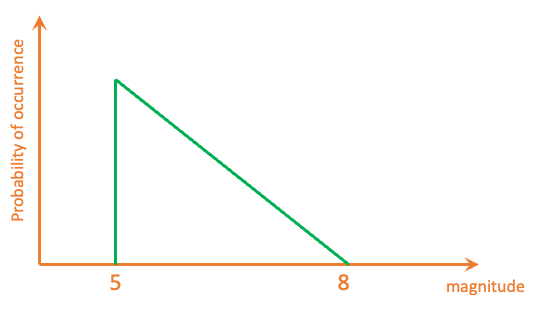

(array([1853., 1766., 1475., 1298., 1094.,  845.,  725.,  520.,  307.,
         117.]),
 array([5.00002825, 5.29584607, 5.59166388, 5.8874817 , 6.18329952,
        6.47911733, 6.77493515, 7.07075297, 7.36657079, 7.6623886 ,
        7.95820642]),
 <BarContainer object of 10 artists>)

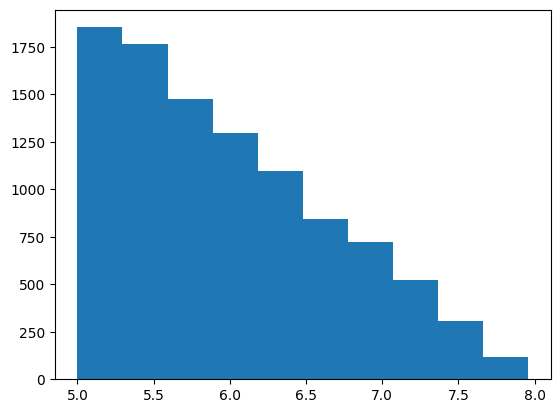

In [11]:
def getEarthquakeMagnitude(mmin = 5, mmed = 5, mmax =8):

    # The triangular distribution is defined by the three points (*) as shown below
    #           * = mmed
    #
    #
    # * = mmin         * = mmax
    #
    # If mmin = mmed or mmed = mmax the triangle has a right angle

    # Define a triangular distribution between mmin and mmax
    return rng.triangular(mmin,mmed,mmax)

# Let's check if our implementation was succesfull by generating 10,000 realizations of the magnitude distribution
plt.hist([getEarthquakeMagnitude() for i in range(10000)])
# I am calling the function getEarthquakeMagnitude() in a for loop that goes from 0-9999, that is 10,000 calls of the function
# I store that as a list, hence the [ ]
# I am using a quick plotting approach, plt.hist()

## <font color='orange'> Ground shaking intensity </font>

The Magnitude is a metric of energy released. This is different from ground shaking intensity because the ground shaking intensity is dependent on *where you are*. If you are on top of the fault line you will experience a lot of shaking. However, if you are multiple kilometres away, the energy in the earthquake waves dissipates as they travel. [We say that the waves attenuate as they travel further](https://www.usgs.gov/media/videos/attenuation#:~:text=The%20waves%20are%20largest%20where,away%20from%20the%20earthquake%20source.).

Ground shaking intensity depends on three factors:

1) If you are 10 kilometres away from the epicentre, the larger the earthquake, the more shaking you will experience;

2) For an earthquake of magnitude 6.5, the further you are from the epicentre the least amount of shaking you will experience;

3) The softer the soil under you the more shaking you will experience.

Multiple scholars have developed models to estimate how much earthquake waves attenuate as they travel. They create *Ground Motion Prediction Equations* (GMPEs) to help us estimate that. These GMPEs are often a function of the Magnitude (M), distance to epicentre (R), and soil properties.

In the following, I give you one example of a GMPE - the Boore, Joyner, Fumal (1997). Note, this GMPE is *obsolete* nowadays. It has been superseded by more sophisticated models that are difficult to implement. However, this GMPE is a good introduction to the topic.

In [12]:
# As long as you understood the concept of attenuation, do not worry too much about this model/GMPE.
def getShakingIntensity(M, R, Vs30): # M: magnitude, R: distance to epicentre, Vs30 is a soil parameter

    # Coefficients of the Boore, Joyner, Fumal (1997) ground motion model for period of 1s.
    # The 'a' coefficients are extracted from linear regression.
    a1 = -3.4415
    a2 = 1.42
    a3 = -0.032
    a4 = -0.798
    a5 = 8.41
    a6 = -0.698

    # Mean spectral acceleration at the 1s period
    ln_a = a1 + a2*M + a3*M**2 + a4*np.log(np.sqrt(R**2 + a5)) + a6*np.log(Vs30)  # np.log is the natural logarithm function; np.sqrt is the squared root

    return np.exp(ln_a) # this function returns ground shaking in "g" (9.81m/s/s)

## <font color='orange'> Simulation </font>

The cell below simulates a single scenario defined by a (i) random magntitude, and (ii) random epicentre location.

In [13]:
nblds = len(df_Alameda.index)


theMagnitude = getEarthquakeMagnitude() # this a function we defined above
theEpicentreLatitude,theEpicentreLongitude = simulateEpicentreLocation()  # this a function we defined above

theDistanceToEpicentreList = []
theShakingIntensityList = []

# For each building in the community (i.e., the number of rows in df_Alameda)
for b in range(nblds):

    # Calculate distance between this building and the epicentre
    coords_1 = (df_Alameda.loc[b,'Latitude'], df_Alameda.loc[b,'Longitude'])
    coords_2 = (theEpicentreLatitude, theEpicentreLongitude)

    # This function calculates the distance between two points on the surface of a geoid (https://www.movable-type.co.uk/scripts/latlong.html)
    # Specifically, the distance between the EQ and buildig 'b'
    theDistanceToEpicentre = geopy.distance.geodesic(coords_1, coords_2).km

    # Calculate shaking intensity at the location of building b
    myShakingIntensity = getShakingIntensity(M=theMagnitude, R=theDistanceToEpicentre, Vs30=300) # this a function we defined above

    theDistanceToEpicentreList.append(theDistanceToEpicentre)
    theShakingIntensityList.append(myShakingIntensity)


df_Alameda['DistanceToEpicentre'] = theDistanceToEpicentreList # in km
df_Alameda['ShakingIntensity'] = theShakingIntensityList #in g

df_Alameda[['Longitude','Latitude','DistanceToEpicentre','ShakingIntensity']].head(3)

Longitude   Latitude  DistanceToEpicentre  ShakingIntensity
0 -122.237670  37.756951             5.230334          0.500531
1 -122.239088  37.734668             7.700398          0.388014
2 -122.233459  37.734820             7.645347          0.389962

Plot the results of the one realization

In [ ]:
# And plot a map with the data underneath
df_plt = df_Alameda.copy()
df_plt['ShakingIntensity'] = df_plt['ShakingIntensity']
df_plt['ShakingIntensity']
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'ShakingIntensity',
                        color_continuous_scale='Viridis',
                        zoom=12.2,
                        height=700,
                        width=800
                      )
fig.show()

## <font color='orange'> Homework Tasks </font>

###<font color='cyan'>Task 1 [10 points]</font>

Create a workflow to represent the model above highlighting the models in the workflow, what data are used in each model, and what elements are uncertain and how the uncertainty is accounted for. The workflow must correctly demonstrate the chain of execution of models, including models that could be run in parallel.



---



---



###<font color='cyan'>Task 2 [15 points] </font>
Starting from the Simulation cell. Create a set of three scenarios with varying magnitudes:

S0 -> M:6.9

S1 -> M:7.0

S2 -> M:7.1

For each scenario, run 50 realizations of the epicentre location. That is, you will run a total of 150 (3x50) simulations. For each scenario, for each building, calculate the <font color='orange'>median</font> ground shaking intensity in *g*. Plot one map of ground shaking intensity per scenario.  

*Suggested approach*:

For each scenario (e.g., M=7.0) you will get a dataframe with one value per REALIZATION:

df_realizations:

| Building | R1 | R2 | ... | R50 |
| ---       | ---   | ---   | ---   | --- |
|1 | 0.5 | 0.3 | ... | 0.67 |
|2 | 0.6 | 0.3 | ... | 0.7 |
|3 | 0.7 | 0.25 | ... | 0.8 |
| ... | ... | ... | ... | ... |
|nblds  | 0.5 | 0.3 | ... | 0.67 |

For each SCENARIO, you want the median of the 50 REALIZATIONS. If the dataframe above is named df_realizations, you can get the median of each row as df_realizations.median(axis=1). Thus, you can simply store one value per building per SCENARIO, that is

df_Means:

| Building | S1 | S2 | ... | S6 |
| ---       | ---   | ---   | ---   | --- |
|1 | 0.5 | 0.3 | ... | 0.67 |
|2 | 0.6 | 0.3 | ... | 0.7 |
|3 | 0.7 | 0.25 | ... | 0.8 |
| ... | ... | ... | ... | ... |
|nblds  | 0.5 | 0.3 | ... | 0.67 |


<font color='green'>Tip</font>: your workflow should run the 3 scenarios with a single click. Do not create a workflow that requires multiple independent runs.

<font color='green'>Tip</font>: During development, build your workflow to run 2 realizations of 2 scenarios. That will be much faster to run and to identify problems. Once you are confident about your workflow, expand to 50 realizations and 3 scenarios.

<font color='green'>Tip</font>: Once you have your dataframe df_Means, add to it the latitute and longitude of each building. That makes plotting the maps easy.

<font color='green'>Tip</font>: Some variables need to change on each simulation, others on each scenario, others are fixed. Make sure your variables are changing at the appropriate times.

<font color='orange'>Warning</font>: 50 realizations is a small amount to get consistent statistics. In practical applications we use thousands or even hundreds of thousands. Thus, you may obtain different results from is shown below, or even if you run your set of simulations multiple times.

In [25]:
df_Medians = pd.DataFrame()
realizations = 5

nblds = len(df_Alameda.index)
scenarios = {
    's0': 6.9,
    's1': 7.0,
    's2': 7.1
}

columns = [f"R{realization}" for realization in range(realizations)]
theMagnitude = getEarthquakeMagnitude() # this a function we defined above
theEpicentreLatitude,theEpicentreLongitude = simulateEpicentreLocation()  # this a function we defined above

theDistanceToEpicentreList = []
theShakingIntensityList = []

for scenario, magnitude in scenarios.items():
  df_realizations = pd.DataFrame()
# For each building in the community (i.e., the number of rows in df_Alameda)
  for realization in columns:
    for b in range(nblds):
        # Calculate distance between this building and the epicentre
        coords_1 = (df_Alameda.loc[b,'Latitude'], df_Alameda.loc[b,'Longitude'])
        coords_2 = (theEpicentreLatitude, theEpicentreLongitude)

        # This function calculates the distance between two points on the surface of a geoid (https://www.movable-type.co.uk/scripts/latlong.html)
        # Specifically, the distance between the EQ and buildig 'b'
        theDistanceToEpicentre = geopy.distance.geodesic(coords_1, coords_2).km

        # Calculate shaking intensity at the location of building b
        shakingIntensity = getShakingIntensity(M=magnitude, R=theDistanceToEpicentre, Vs30=300) # this a function we defined above
        theDistanceToEpicentreList.append(theDistanceToEpicentre)
        df_realizations.loc[b, realization] = shakingIntensity

    df_Medians[scenario] = df_realizations.median(axis=1)
df_Medians = pd.merge(df_Medians, df_Alameda[['Latitude', 'Longitude']], left_index=True, right_index=True)
df_Medians

s0        s1        s2   Latitude   Longitude
0      0.175173  0.193117  0.212762  37.756951 -122.237670
1      0.164258  0.181083  0.199505  37.734668 -122.239088
2      0.163367  0.180102  0.198423  37.734820 -122.233459
3      0.177638  0.195834  0.215755  37.758740 -122.244661
4      0.188959  0.208315  0.229506  37.769787 -122.266297
...         ...       ...       ...        ...         ...
15423  0.204203  0.225120  0.248022  37.785907 -122.282454
15424  0.168713  0.185995  0.204916  37.738752 -122.253801
15425  0.168815  0.186108  0.205040  37.738681 -122.254643
15426  0.177934  0.196160  0.216115  37.763473 -122.234257
15427  0.175189  0.193134  0.212781  37.760491 -122.229248

[15428 rows x 5 columns]

In [ ]:
# Your dataframe should look like this at the end
df_Medians

S0        S1        S2   Latitude   Longitude
0      0.336296  0.401366  0.414600  37.756951 -122.237670
1      0.315056  0.369531  0.384678  37.734668 -122.239088
2      0.322015  0.378101  0.392545  37.734820 -122.233459
3      0.328864  0.391422  0.408455  37.758740 -122.244661
4      0.313789  0.368148  0.398449  37.769787 -122.266297
...         ...       ...       ...        ...         ...
15423  0.313222  0.359287  0.400624  37.785907 -122.282454
15424  0.302340  0.353723  0.371363  37.738752 -122.253801
15425  0.301400  0.352489  0.370280  37.738681 -122.254643
15426  0.345130  0.415363  0.427200  37.763473 -122.234257
15427  0.349966  0.420929  0.429215  37.760491 -122.229248

[15428 rows x 5 columns]

In [27]:
# Use this code to plot the maps
df_plt = df_Medians.copy() # df_Medians contain the median for each building for each scenario.

gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig1 = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 's0', # Results from Scenario 0
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )

fig2 = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 's1',
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )

fig3 = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 's2',
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )


fig1.show(), fig2.show(), fig3.show()

(None, None, None)



---



---



###<font color='cyan'>Task 3 [15 points]</font>

In the previous task we explored the Outcome Space randomly. That is, we randomly assigned the Epicentre Location using Monte Carlo Sampling. This procedure works well (and is simple to use) when we have a large number of samples (i.e., 1000s). If we are limited to a few samples, say due to it being too computationally costly to run many more, there are smarter ways to evaluate our Outcome Space. Say we want to evaluate the probability that a given building will experience *0.4g or more* of ground shaking. If you run 51 Monte Carlo Samples (i.e., to split the fault into 50 segments) randomly assigning the Epicentre location, the 51 samples can fall close (or far) from the city and not give you a good coverage all possible outcomes.

In this task, we will *force* a consistent variability in results. To do so, simulate 50 equally spaced epicentre locations that cover the entire Fault line. That is, if the fault line was 50 km, your Epicentre locations should be spaced 1km apart and the initial and end points of the Fault line should be the first and last points in this list (51 points total). Let's call this list *theListOfEpicentres*.

For each Scenario above (i.e., S0, S1, and S2), calculate the ground shaking intensity at each building for each location in *theListOfEpicentres*.

Then, plot a histogram.



/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning:

'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.



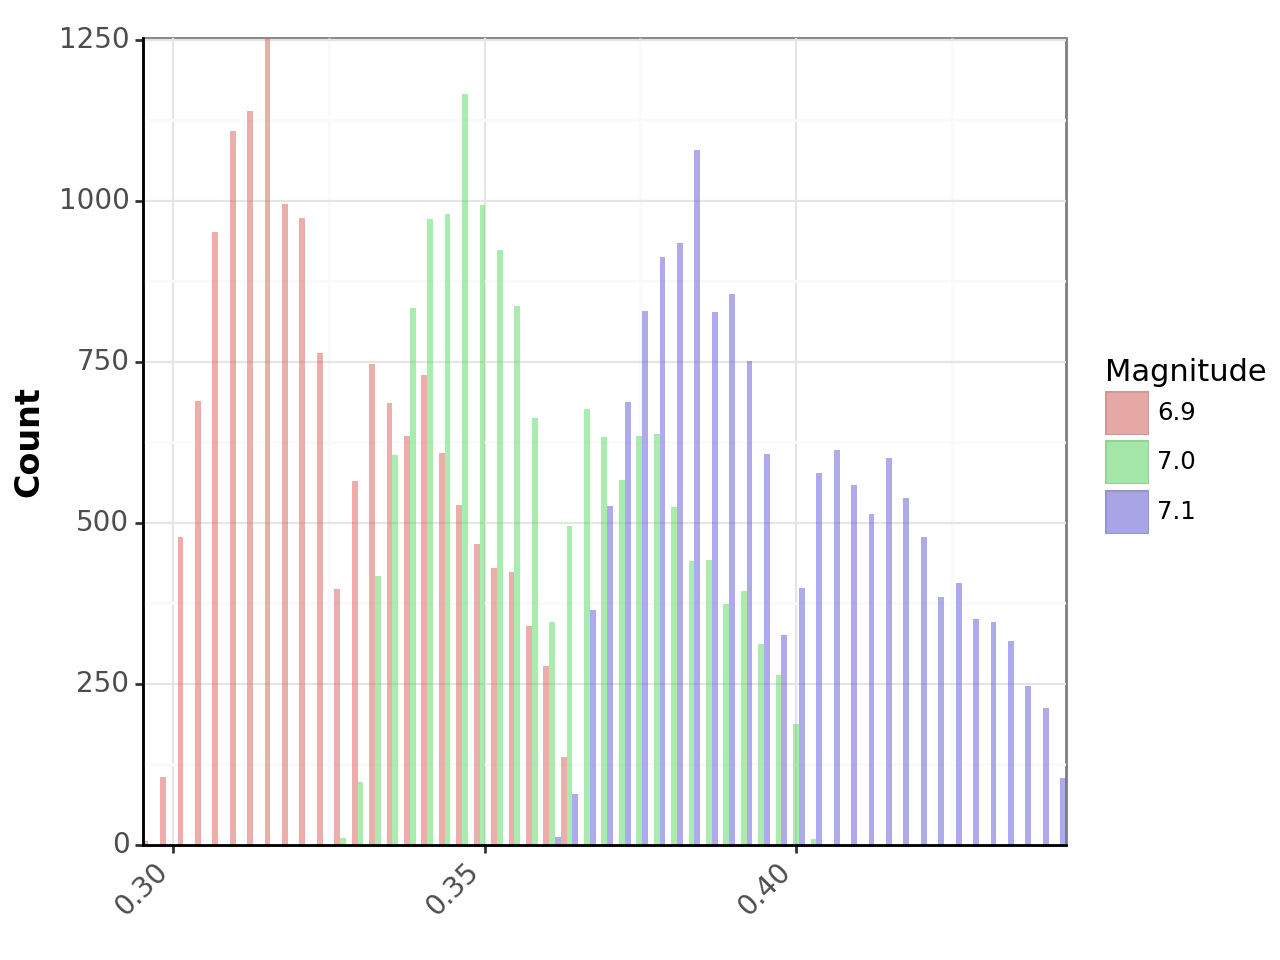

<Figure Size: (640 x 480)>

In [ ]:
# This code should produce a histogram of your data if it was correctly organized
df_plot = df_Median.drop(['Latitude','Longitude'],axis=1).rename(columns={"S0":'6.9',
                                                                         "S1":'7.0',
                                                                         'S2':'7.1',
                                                                         })

df_plot_long = pd.melt(df_plot)

plot_base = ggplot(df_plot_long,aes(x='value',fill='variable',group='variable')) + geom_histogram(alpha=0.5,position='dodge')

plot_clean = plot_base + theme_bw() + theme(
  axis_line=element_line(size=1),
  axis_text=element_text(size=10),
  axis_title=element_text(size=12,face="bold"),
  axis_text_x = element_text(angle = 45, hjust=1),
) +\
labs(fill='Magnitude') +\
scale_x_continuous(name = '',expand=[0,0]) +\
scale_y_continuous(name = 'Count',expand=[0,0])
plot_clean

In [ ]:
###
# The code I used was in this cell (note, you will likely not get the same values, use the histogram above to 'sanity check' your results.)
###

The probability that a building will experience shaking larger than 0.4g in scenario S0 is 0.0
The probability that a building will experience shaking larger than 0.4g in scenario S1 is 0.006157635467980296
The probability that a building will experience shaking larger than 0.4g in scenario S2 is 0.4185247601763028




---



---



###<font color='cyan'>Task 4 [10 Points]</font>

You receive new information and now must update your *analyses* accordingly. The new information suggests that there are three sections in Hayward Fault and each section can generate earthquakes with different magnitudes. This information is schamatically shown below where the thick, black dashed line represents the Hayward Fault. Each segment has a magnitude model associated with it. The only change refers to the Mmax (maximum magnitude).
Your task is to simulate one earthquake in each point in *theListOfEpicentres* assigning a magnitude randomly selected from the Magnitude Model. From these 51 realizations, calculate the median ground shaking intensity in each building and plot them in a map.

<font color='green'>Tip</font>: This task is about structuring the simulation, not the results because the number of realizations is too small to obtain results that are meaningful.

<font color='green'>Tip</font>: You have completed most of the work needed to solve this task in the previous tasks. A smart "copy, paste, rearrange" of the code from Task 4 will get you very close to the solution to this task.

In [ ]:
###
# Your code goes here
###


# These are my results - yours will be different due to few samples
# But the structure should be similar

R0        R1        R2        R3        R4        R5        R6  \
0      0.053897  0.030596  0.055731  0.148561  0.070416  0.134307  0.050705   
1      0.057027  0.032436  0.059203  0.158157  0.075134  0.143642  0.054360   
2      0.057764  0.032880  0.060064  0.160604  0.076376  0.146188  0.055398   
3      0.052892  0.029999  0.054590  0.145363  0.068819  0.131087  0.049417   
4      0.049358  0.027912  0.050629  0.134344  0.063360  0.120187  0.045100   
...         ...       ...       ...       ...       ...       ...       ...   
15423  0.046238  0.026085  0.047192  0.124879  0.058720  0.111027  0.041518   
15424  0.054550  0.030959  0.056370  0.150186  0.071137  0.135559  0.051117   
15425  0.054455  0.030902  0.056260  0.149875  0.070981  0.135240  0.050988   
15426  0.053313  0.030255  0.055091  0.146803  0.069558  0.132621  0.050050   
15427  0.054282  0.030830  0.056188  0.149872  0.071088  0.135700  0.051279   

             R7        R8        R9  ...       R41       R42       R43  \
0      0.037847  0.037883  0.219465  ...  0.089944  0.066044  0.061502   
1      0.040675  0.040814  0.237004  ...  0.082668  0.060957  0.056981   
2      0.041514  0.041729  0.242804  ...  0.082167  0.060593  0.056647   
3      0.036825  0.036792  0.212703  ...  0.091510  0.067151  0.062494   
4      0.033439  0.033223  0.190882  ...  0.098913  0.072352  0.067134   
...         ...       ...       ...  ...       ...       ...       ...   
15423  0.030667  0.030344  0.173567  ...  0.109460  0.079681  0.073604   
15424  0.038094  0.038054  0.219873  ...  0.085339  0.062867  0.058713   
15425  0.037991  0.037942  0.219175  ...  0.085390  0.062905  0.058749   
15426  0.037344  0.037366  0.216406  ...  0.091878  0.067383  0.062679   
15427  0.038317  0.038403  0.222823  ...  0.090068  0.066114  0.061550   

            R44       R45       R46       R47       R48       R49       R50  
0      0.032624  0.040007  0.043545  0.025773  0.025778  0.094618  0.071391  
1      0.030331  0.037314  0.040733  0.024174  0.024240  0.089178  0.067432  
2      0.030157  0.037104  0.040508  0.024043  0.024111  0.088715  0.067089  
3      0.033132  0.040607  0.044176  0.026134  0.026128  0.095860  0.072300  
4      0.035493  0.043388  0.047086  0.027792  0.027727  0.101523  0.076427  
...         ...       ...       ...       ...       ...       ...       ...  
15423  0.038752  0.047192  0.051034  0.030024  0.029861  0.109030  0.081862  
15424  0.031226  0.038383  0.041867  0.024828  0.024877  0.091458  0.069110  
15425  0.031246  0.038407  0.041892  0.024843  0.024892  0.091512  0.069150  
15426  0.033216  0.040697  0.044260  0.026177  0.026165  0.095976  0.072375  
15427  0.032642  0.040022  0.043554  0.025775  0.025777  0.094604  0.071374  

[15428 rows x 51 columns]

In [ ]:
# If the results above are saved in a data frame called df_Realizations then you can plot it as below

df_Median = pd.DataFrame()
df_Median['Median'] = df_Realizations.median(axis=1)

df_Median['Latitude'] = df_Alameda['Latitude']
df_Median['Longitude'] = df_Alameda['Longitude']

df_plt = df_Median.copy() # df_Means contain the median for each building for each scenario.

gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

# Showing 2 scenarios
fig1 = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'Median', # Results from Scenario 0
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )

fig1



---



---



# <font color='orange'> Question 2 [20 points] </font>

Consider our in-class example of the model for making toast. Below are some of the variables that I included in my solution. We assumed values for these variables in our example. Now, select 3 of the variables and *identify* an empirically-backed model to represent these variables. Here, identify refers to finding it in the literature (e.g., academic papers, instruction manuals). For some models, e.g., probability of rain, you will may need to define context (e.g., proability of raining in Waterloo in July). You will need to do a similar process for your class projects. The goal of this problem is to start to excercise that skill.

In [ ]:
'''
c = bread consumption
b = amount of bread bought
d = days between grocery shopping
r = prob. of rain
m = prob. toaster malfunction
p2 = prob. of butter going bad if power is down
'''